In [1]:
#Libraries import
import pandas as pd
from mordred import Calculator, descriptors
import mordred
import numpy as np
from rdkit import Chem

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

import joblib


In [2]:
def prepare_data(file):
    
    df = pd.read_excel(file)
    
    try:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['SMILES']]
    except:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['new_SMILES']]
    
    calculate_descriptors = True
    
    if calculate_descriptors:
        calc = Calculator(descriptors, ignore_3D=True)
        molecular_descriptors = calc.pandas(mol_objs)
        molecular_descriptors = molecular_descriptors.applymap(is_morder_missing)
        molecular_descriptors = molecular_descriptors[sorted(molecular_descriptors.columns)]
    else:
        pass
    print(molecular_descriptors.shape)
    
    simple_preprocessing = True
    if simple_preprocessing:
        molecular_descriptors_cleaned = molecular_descriptors.dropna(axis=1, how='any')
        molecular_descriptors_cleaned
    print(molecular_descriptors_cleaned.shape)
    molecular_descriptors_cleaned = molecular_descriptors_cleaned.loc[:, (molecular_descriptors_cleaned != 0).any(axis=0)]
    print(molecular_descriptors_cleaned.shape)
    
    try:
        molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] = df['Aktywność cytoprotekcyjna [%]']
    except:
        pass
    
    #try:
        #print('Target distribution histogram: ')
        #print(df['Aktywność cytoprotekcyjna [%]'].hist())
    #except:
        #pass
    
    return molecular_descriptors_cleaned

In [3]:
def is_morder_missing(x):
    return np.nan if type(x) == mordred.error.Missing or type(x) == mordred.error.Error else x 

In [4]:
def correlation_dataframe(molecular_descriptors_cleaned, correlation_threshold):
    
    correlation_table = pd.DataFrame(data=molecular_descriptors_cleaned.columns.to_list(), columns=["molecular descriptor name"])
    print(correlation_table.head())
    correlation_to_ak_cyt = []
    for mol_desc in correlation_table['molecular descriptor name']:
        x = np.corrcoef(np.array(molecular_descriptors_cleaned[mol_desc]), np.array(molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]']))
        x = x.tolist()[0][1]
        correlation_to_ak_cyt.append(x)
    correlation_table['corr_value'] = correlation_to_ak_cyt
    print(correlation_table.head())
    correlation_table['absolute correlation value'] = [abs(x) for x in correlation_table['corr_value']]
    print(correlation_table[:-1].head())
    
    mol_desc_best_corr = correlation_table[correlation_table['absolute correlation value'] > correlation_threshold]
    
    print(mol_desc_best_corr.head())
    table_with_descriptors_to_be_used = mol_desc_best_corr[:-1]
    print(table_with_descriptors_to_be_used.head())
    
    #print("Correlation to the target histogram: ")
    #print(correlation_table['absolute correlation value'][:-1].hist(bins=100))
    
    return table_with_descriptors_to_be_used
    

In [5]:
def prepare_model(data, features, n_estimators_):
    
    X_train, X_test, y_train, y_test = train_test_split(data[features['molecular descriptor name']], 
                                                        data['Aktywność cytoprotekcyjna [%]'], 
                                                        test_size=3/58, random_state=42)
    
    randfor = RandomForestRegressor(random_state=15, n_estimators=n_estimators_)
    
    randfor.fit(X_train, y_train)
    print("Return the coefficient of determination of the prediction: ")
    print(randfor.score(X_test, y_test))
    
    pred = randfor.predict(X_train)
    print("R^2 score: "+ str(r2_score(y_train, pred)))
    sqrt_r2 = np.sqrt(r2_score(y_train, pred))
    training_data_r2 = r2_score(y_train, pred)
    print('Correlation coefficient: '+ str(sqrt_r2))
    print("Test data - unseen during training:")
    pred = randfor.predict(X_test)
    print("R^2 score: "+ str(r2_score(pred, y_test)))
    sqrt_r2 = np.sqrt(r2_score(pred, y_test))
    print('Correlation coefficient: '+ str(sqrt_r2))
    print(pred)
    print(y_test) 
    test_data_r2 = r2_score(pred, y_test)
    

    return randfor, training_data_r2, test_data_r2
    

In [6]:
def data_standarization(dataframe):
    
    dataframe_ = dataframe.drop(['Aktywność cytoprotekcyjna [%]'], axis=1)
    
    to_be_returned = (dataframe_ - dataframe_.mean()) / dataframe_.std()
    to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']
    
    return to_be_returned

In [7]:
def prepare_data_and_create_model(molecular_descriptors_df, correlation_threshold, standarization, n_estimators_):
    
    if standarization == True:
        
        print("I am doing standarization...")
        
        data_to_be_prepared = molecular_descriptors_df
        
        stand = data_standarization(data_to_be_prepared)
        
        corr = correlation_dataframe(stand, correlation_threshold)
        
        #test_ = test_data(stand)
        
        #data_to_be_prepared = stand.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(stand, corr, n_estimators_) #data_to_be_prepared
        
    elif standarization == False:
        
        print("I am not doing standarization...")
        
        data_to_be_prepared = molecular_descriptors_df
        
        corr = correlation_dataframe(data_to_be_prepared, correlation_threshold)
        
        #test_ = test_data(data_to_be_prepared)
        
        #data_to_be_prepared = data_to_be_prepared.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(data_to_be_prepared, corr, n_estimators_) #data_to_be_prepared
    else:
        print("Error...")
    
    return model, train_r2, test_r2, data_to_be_prepared, corr
    

In [8]:
molecular_descriptors_df = prepare_data('../Data/initial_caffeine.xlsx')

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 27.42it/s]


(58, 1613)
(58, 1388)
(58, 1137)


In [9]:
without_standarization, train_r2_, test_r2_, hist1, hist2 = prepare_data_and_create_model(molecular_descriptors_df, 0.47, False, 5)

I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


In [10]:
without_standarization.predict(molecular_descriptors_df[hist2['molecular descriptor name']])

array([24.4, 40. , 52. , 20. , 10. ,  8. ,  7. ,  0. ,  8. , 53. , 51.8,
       30. , 47. , 33. ,  6.6, 50. , 27. ,  2. ,  6.6,  9. , 10. ,  2. ,
       14.2, 19. ,  6. , 10. , 13.2,  5. , 57. , 21. , 33. , 71. , 72. ,
       43. , 36. , 30. , 35. , 90. , 57. , 53. , 69. , 54. , 59.6, 12.8,
       15.6, 24. , 29. , 45. , 20. , 28. , 24.2, 40.6, 34.4, 34.6,  0.8,
       26.4, 22.8, 31.8])

In [11]:
xs = r2_score(without_standarization.predict(molecular_descriptors_df[hist2['molecular descriptor name']]), molecular_descriptors_df['Aktywność cytoprotekcyjna [%]'])

In [12]:
xs

0.605417046178302

In [13]:
np.sqrt(xs)

0.7780855005578128

Target distribution histogram: 
AxesSubplot(0.125,0.11;0.775x0.77)


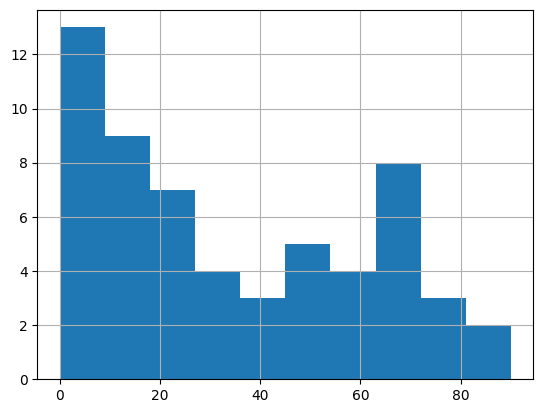

In [14]:
print('Target distribution histogram: ')
print(hist1['Aktywność cytoprotekcyjna [%]'].hist())

In [15]:
print("Number of features (molecular descriptors used): "+ str(len(hist2)))

Number of features (molecular descriptors used): 2


In [16]:
hist2

,molecular descriptor name,corr_value,absolute correlation value
362,ATSC4s,-0.482595,0.482595
530,GATS2Z,-0.472027,0.472027


In [17]:
with_standarization, train_r2__, test_r2__, hist1_, hist2_ = prepare_data_and_create_model(molecular_descriptors_df, 0.39, True, 12)

I am doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i


C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


In [18]:
with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']])

array([32.58333333, 33.83333333, 31.33333333, 30.08333333, 30.08333333,
       30.91666667, 31.33333333, 27.        , 28.83333333, 31.33333333,
       30.91666667, 30.91666667, 30.5       , 30.5       , 30.5       ,
       30.08333333, 29.66666667, 30.08333333, 29.66666667, 29.66666667,
       30.08333333, 29.66666667, 30.91666667, 30.08333333, 30.08333333,
       28.83333333, 28.83333333, 31.75      , 31.75      , 31.75      ,
       31.75      , 31.75      , 31.75      , 31.75      , 31.75      ,
       31.75      , 33.41666667, 33.41666667, 33.41666667, 31.08333333,
       31.08333333, 31.08333333, 31.08333333, 30.08333333, 29.25      ,
       31.75      , 30.08333333, 30.5       , 30.5       , 30.5       ,
       30.5       , 32.16666667, 32.16666667, 30.91666667, 28.08333333,
       32.16666667, 32.16666667, 32.16666667])

In [19]:
xs = r2_score(with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']]), molecular_descriptors_df['Aktywność cytoprotekcyjna [%]'])

In [20]:
xs

-425.52561884385017

## Search inside correlation space

In [21]:
step = 0.01
initial_step = 0.3
last_step = 0.48
first_list = [x / 100.0 for x in range(int(initial_step*100), int(last_step*100), int(step*100))]
n_estimators = [range(2,21,1)]
corr_th = []
second_list = []
third_list = []
f_list = []
fif_list = []
for i in first_list:
    
    for estimator in n_estimators[0]:
        
        without_standarization, train_r2, test_r2, _, h_ = prepare_data_and_create_model(molecular_descriptors_df, i, False, estimator)
        corr_th.append(i)
        second_list.append(train_r2)
        third_list.append(test_r2)
        f_list.append(len(h_))
        fif_list.append(estimator)


I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7            

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Return the coefficient of determination of the prediction: 
0.14537741833174767
R^2 score: 0.7258445387448942
Correlation coefficient: 0.8519651041826151
Test data - unseen during training:
R^2 score: -1.7921163975477077
Correlation coefficient: nan
[51.66666667 28.66666667 70.        ]
0     12
5      0
34    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                   

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Return the coefficient of determination of the prediction: 
-0.2571955280685061
R^2 score: 0.8654884042721736
Correlation coefficient: 0.9303162925974012
Test data - unseen during training:
R^2 score: -23.95985832349469
Correlation coefficient: nan
[32.5 49.  43.5]
0     12
5      0
34    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2           

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Return the coefficient of determination of the prediction: 
-0.18212042323008037
R^2 score: 0.8787569516762185
Correlation coefficient: 0.9374203708455553
Test data - unseen during training:
R^2 score: -195.5289271329183
Correlation coefficient: nan
[35.88888889 41.66666667 38.27777778]
0     12
5      0
34    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                   

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Correlation coefficient: nan
[34.58333333 39.75       41.        ]
0     12
5      0
34    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   mole

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Return the coefficient of determination of the prediction: 
0.38319000852705787
R^2 score: 0.9158060566710384
Correlation coefficient: 0.9569775633059735
Test data - unseen during training:
R^2 score: -2.6777874295137005
Correlation coefficient: nan
[19.70588235 35.82352941 50.35294118]
0     12
5      0
34    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                   

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Return the coefficient of determination of the prediction: 
0.5337946994925469
R^2 score: 0.8752726402389955
Correlation coefficient: 0.9355600676808494
Test data - unseen during training:
R^2 score: -0.36900275033105867
Correlation coefficient: nan
[13.         33.58333333 56.66666667]
0     12
5      0
34    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                   

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Return the coefficient of determination of the prediction: 
0.4226247699505168
R^2 score: 0.9036385442430235
Correlation coefficient: 0.9505990449411484
Test data - unseen during training:
R^2 score: -1.6385423209872827
Correlation coefficient: nan
[17.05882353 35.64705882 52.05882353]
0     12
5      0
34    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Return the coefficient of determination of the prediction: 
0.3590737987630829
R^2 score: 0.8951989958229251
Correlation coefficient: 0.9461495631362544
Test data - unseen during training:
R^2 score: -2.08465488078168
Correlation coefficient: nan
[18.5  38.05 52.5 ]
0     12
5      0
34    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2          

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Correlation coefficient: nan
[36.07692308 16.46153846 43.84615385]
0     12
5      0
34    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    mol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\AppData\Local\Temp\ipykernel_1044\2449727538.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


In [22]:
df_without_standarization = pd.DataFrame(data=corr_th, columns=["Correlation threshold"])

In [23]:
df_without_standarization['Training data R^2 score'] = second_list
df_without_standarization['Test data R^2 score'] = third_list
df_without_standarization['Number of features'] = f_list
df_without_standarization['Number of estimators'] = fif_list

In [24]:
df_without_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features,Number of estimators
0,0.30,0.710042,-2.536344,87,2
1,0.30,0.725845,-1.792116,87,3
2,0.30,0.761492,-28.943620,87,4
3,0.30,0.832521,-19.230822,87,5
4,0.30,0.868726,-7.438612,87,6
...,...,...,...,...,...
337,0.47,0.825835,-1.098413,2,16
338,0.47,0.832110,-1.029953,2,17
339,0.47,0.820396,-1.218394,2,18
340,0.47,0.827922,-1.366298,2,19


## Plots

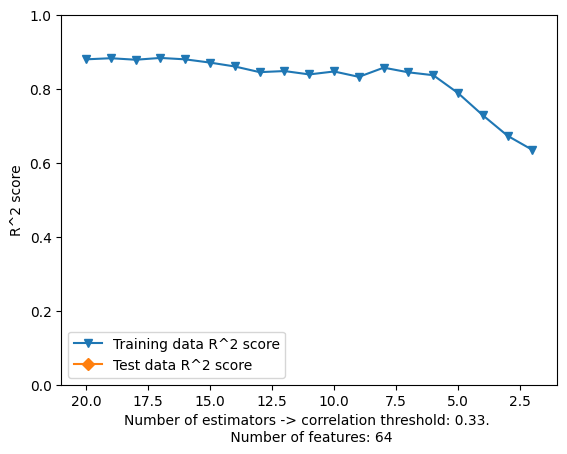

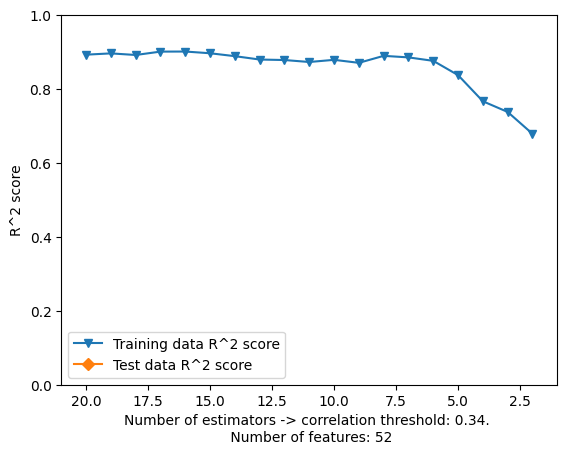

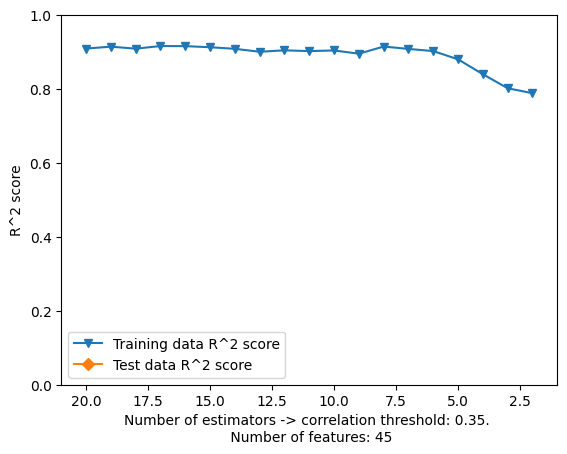

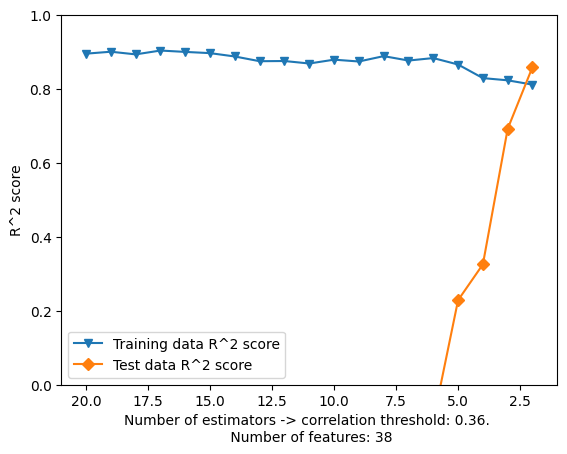

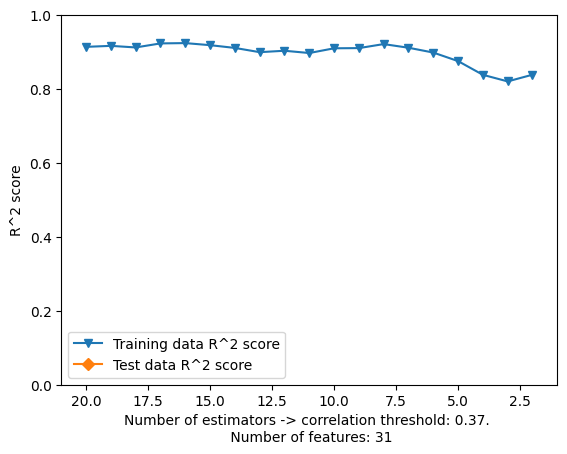

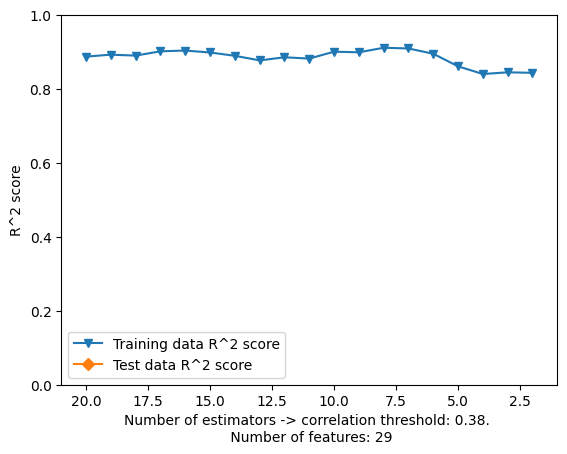

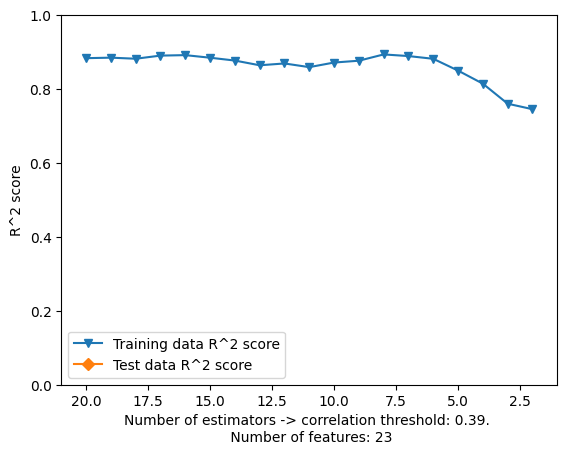

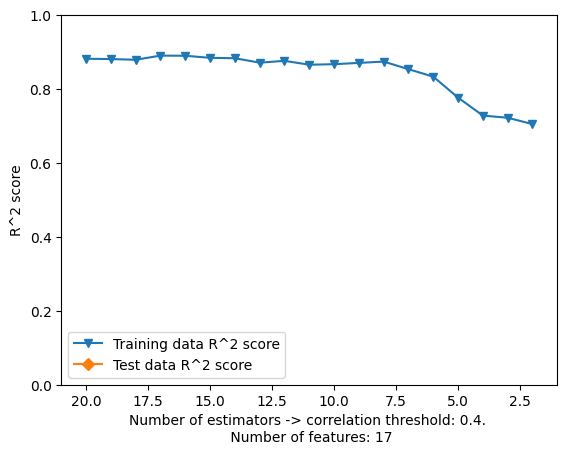

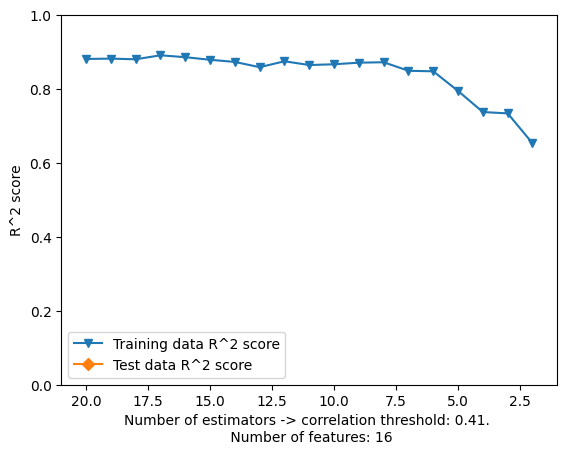

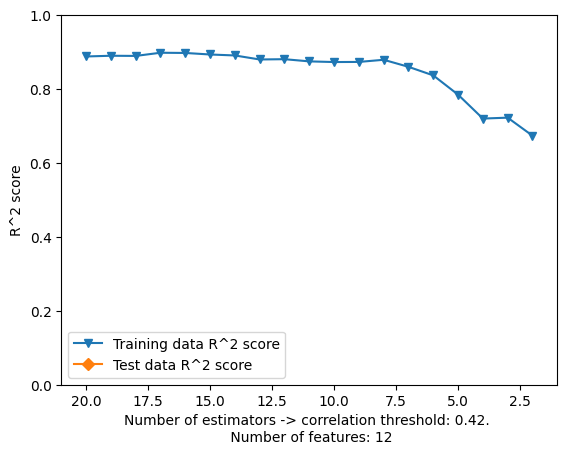

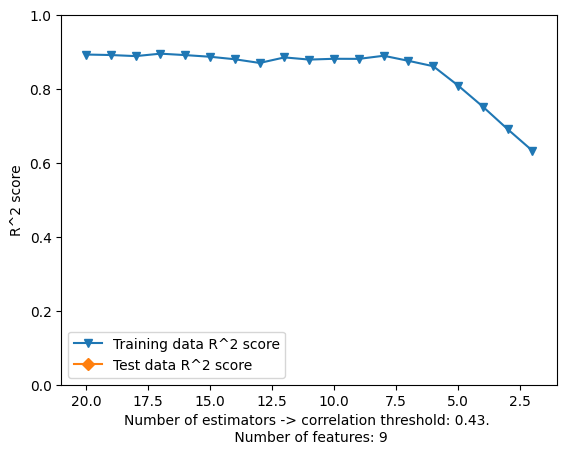

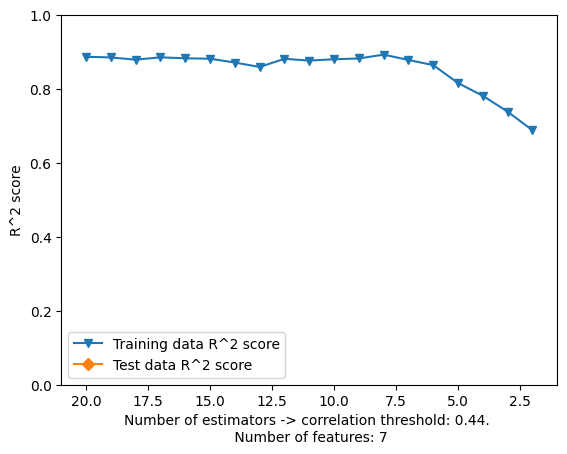

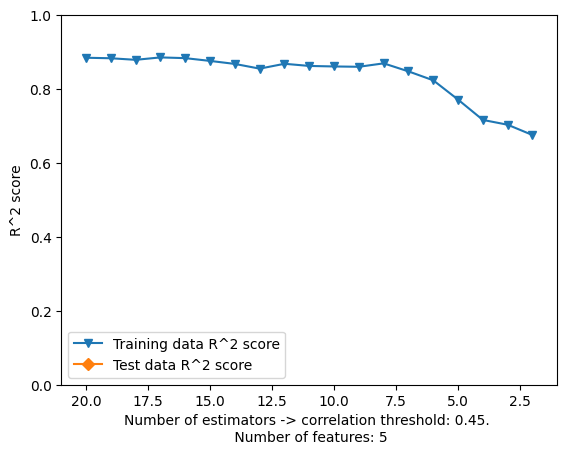

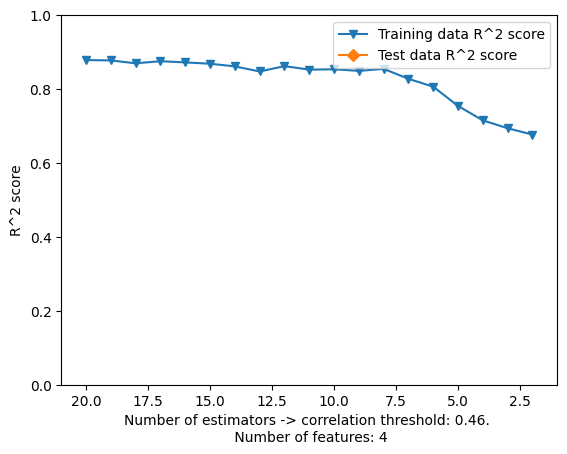

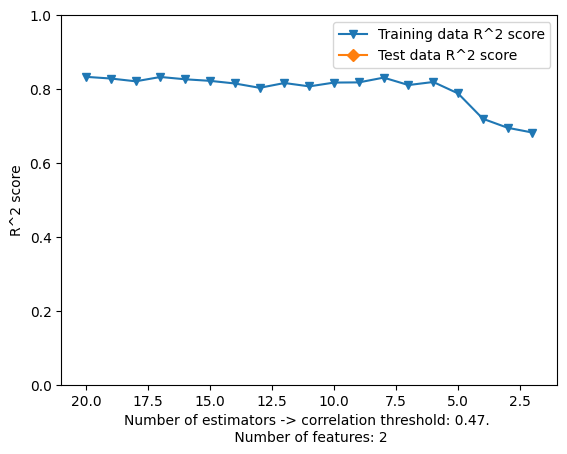

In [25]:
corre_list = [x / 100.0 for x in range(int(0.33*100), int(0.48*100), int(0.01*100))]
for element in corre_list:
    element_ = df_without_standarization[df_without_standarization['Correlation threshold'] == float(element)]
    plt.plot(element_['Number of estimators'], element_['Training data R^2 score'], label = "Training data R^2 score", marker='v')
    plt.plot(element_['Number of estimators'], element_['Test data R^2 score'], label = "Test data R^2 score", marker='D')
    plt.legend()
    plt.xlabel('Number of estimators -> correlation threshold: '+str(element)+'. \n Number of features: '+str(element_['Number of features'].iloc[0]))
    plt.xlim(max(element_['Number of estimators'])+1, min(element_['Number of estimators'])-1)
    plt.ylabel('R^2 score')
    plt.ylim([0, 1])
    plt.show()

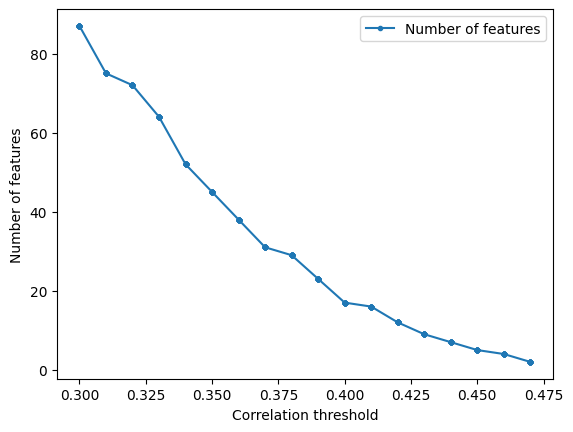

In [26]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Number of features'], label = "Number of features", marker='.')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('Number of features')
plt.show()

In [27]:
element_ = df_without_standarization[df_without_standarization['Correlation threshold'] == 0.47]
element_

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features,Number of estimators
323,0.47,0.681732,-27.749538,2,2
324,0.47,0.694603,-36.703583,2,3
325,0.47,0.719055,-3.910225,2,4
326,0.47,0.787585,-2.470493,2,5
327,0.47,0.818552,-4.005789,2,6
328,0.47,0.810255,-4.845495,2,7
329,0.47,0.830361,-5.794265,2,8
330,0.47,0.817470,-4.355519,2,9
331,0.47,0.816960,-2.265864,2,10
332,0.47,0.806664,-1.380684,2,11


# sqrt(R^2)

In [ ]:
r_a = df_without_standarization[df_without_standarization['Correlation threshold'] == 0.47]

In [ ]:
r_a['train R value'] = [np.sqrt(x) for x in r_a['Training data R^2 score']]

In [ ]:
xcz = []
for element in r_a['Test data R^2 score']:
    x = np.sqrt(element)
    try:
        if x > 0:
            xcz.append(x)
        else:
            xcz.append(0)
    except:
        pass
    

In [ ]:
xcz

In [ ]:
r_a['test R value'] = xcz

In [ ]:
plt.plot(r_a['Number of estimators'], r_a['train R value'], label = "train R value", marker='v')
plt.plot(r_a['Number of estimators'], r_a['test R value'], label = "test R value", marker='D')
plt.legend()
plt.xlabel('Number of estimators -> correlation threshold: 0.39')
plt.ylabel('R score')
plt.ylim([0, 1])
plt.show()

## Final model

In [ ]:
final_model = prepare_data_and_create_model(molecular_descriptors_df, 0.39, False, 12)

In [ ]:
final_model[0].estimators_

In [ ]:
for x, decision_tree in enumerate(final_model[0].estimators_):
    plt.figure(figsize=(10,8), dpi=150)
    plot_tree(decision_tree, feature_names=list(final_model[4]['molecular descriptor name']))
    #plt.savefig('Random_forest/random_forest'+str(x)+'.svg')

In [ ]:
final_model[4]

In [ ]:
# save
joblib.dump(final_model[0], "random_forest_model.joblib")
# load, no need to initialize the loaded_rf
loaded_rf = joblib.load("random_forest_model.joblib")

In [ ]:
loaded_rf.predict(molecular_descriptors_df[final_model[4]['molecular descriptor name']])

In [ ]:
molecular_descriptors_df['Aktywność cytoprotekcyjna [%]']

In [ ]:
xsz = r2_score(loaded_rf.predict(molecular_descriptors_df[final_model[4]['molecular descriptor name']]), molecular_descriptors_df['Aktywność cytoprotekcyjna [%]'])
xsz

In [ ]:
np.sqrt(xsz)

## Predict target feature

In [ ]:
to_prediction = prepare_data('../Data/Proposed_structures_with_AI_caffeine_tanimoto_similarity_.xlsx')

In [ ]:
predicted_activity = loaded_rf.predict(to_prediction[final_model[4]['molecular descriptor name']])

In [ ]:
smiles = pd.read_excel('../Data/Proposed_structures_with_AI_caffeine_tanimoto_similarity_.xlsx')
smiles = smiles['new_SMILES']
smiles = smiles.to_list()
save_to_df = pd.DataFrame(data=smiles, columns=['SMILES'])

In [ ]:
print(len(smiles))
print(len(predicted_activity))

In [ ]:
save_to_df.head()

In [ ]:
save_to_df['Predicted activity'] = predicted_activity

In [ ]:
save_to_df.head()

In [ ]:
save_to_df.to_excel('../Data/Predicted_random_forest.xlsx')